<a href="https://colab.research.google.com/github/ethvedbitdesjan/NLP/blob/main/Fine_tuning_LayoutLMv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we are going to fine-tune `LayoutLMv2ForTokenClassification` on the [CORD](https://github.com/clovaai/cord) dataset. The goal for the model is to label words appearing in scanned documents (namely, receipts) appropriately. This task is treated as a NER problem (sequence labeling). However, compared to BERT, LayoutLMv2 also incorporates visual and layout information about the tokens when encoding them into vectors. This makes the LayoutLMv2 model very powerful for document understanding tasks.

LayoutLMv2 is itself an upgrade of LayoutLM. The main novelty of LayoutLMv2 is that it also pre-trains visual embeddings, whereas the original LayoutLM only adds visual embeddings during fine-tuning.

* Paper: https://arxiv.org/abs/2012.14740
* Original repo: https://github.com/microsoft/unilm/tree/master/layoutlmv2

NOTES: 

* you first need to prepare the CORD dataset for LayoutLMv2. For that, check out the notebook "Prepare CORD for LayoutLMv2".
* this notebook is heavily inspired by [this Github repository](https://github.com/omarsou/layoutlm_CORD), which fine-tunes both BERT and LayoutLM (v1) on the CORD dataset.



## Install dependencies

First, we install the required libraries:
* Transformers (for the LayoutLMv2 model)
* Datasets (for data preprocessing)
* Seqeval (for metrics)
* Detectron2 (which LayoutLMv2 requires for its visual backbone).



In [1]:
!rm -r transformers
!git clone -b modeling_layoutlmv2_v2 https://github.com/NielsRogge/transformers.git
!cd tranformers
!pip install -q ./transformers

Cloning into 'transformers'...
remote: Enumerating objects: 156369, done.
remote: Total 156369 (delta 0), reused 0 (delta 0), pack-reused 156369
Receiving objects: 100% (156369/156369), 128.35 MiB | 16.42 MiB/s, done.
Resolving deltas: 100% (116133/116133), done.
/bin/bash: line 0: cd: tranformers: No such file or directory
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [2]:
!pip install -q datasets seqeval

In [3]:
"""
!sudo apt install tesseract-ocr
!pip install pytesseract
"""

'\n!sudo apt install tesseract-ocr\n!pip install pytesseract\n'

In [4]:
"""
!pip install pyyaml==5.1
# workaround: install old version of pytorch since detectron2 hasn't released packages for pytorch 1.9 (issue: https://github.com/facebookresearch/detectron2/issues/3158)
!pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# install detectron2 that matches pytorch 1.8
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install -q detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime
"""

'\n!pip install pyyaml==5.1\n# workaround: install old version of pytorch since detectron2 hasn\'t released packages for pytorch 1.9 (issue: https://github.com/facebookresearch/detectron2/issues/3158)\n!pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html\n\n# install detectron2 that matches pytorch 1.8\n# See https://detectron2.readthedocs.io/tutorials/install.html for instructions\n!pip install -q detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html\n# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime\n'

In [5]:
import torch
print(torch.__version__)

1.8.0+cu101


## Prepare the data

First, let's read in the annotations which we prepared in the other notebook. These contain the word-level annotations (words, labels, normalized bounding boxes).

In [6]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [7]:
%cd '/content/gdrive/MyDrive/Resume_Info_Extraction/'

/content/gdrive/MyDrive/Resume_Info_Extraction


In [8]:
import pandas as pd

train = pd.read_pickle('train.pkl')
test = pd.read_pickle('test.pkl')

Let's define a list of all unique labels. For that, let's first count the number of occurrences for each label:

In [9]:
from collections import Counter

all_labels = [item for sublist in train[3] for item in sublist] + [item for sublist in test[3] for item in sublist]
Counter(all_labels)

Counter({'Name': 17,
         'Other': 148,
         'Universities': 23,
         'Skills': 46,
         'Past_Companies': 45,
         'Email': 14,
         'Phone': 14,
         'Degrees': 26,
         'Designations': 54})

As we can see, there are some labels that contain very few examples. Let's replace them by the "neutral" label "O" (which stands for "Outside").

In [10]:
all_labels = [item for sublist in train[3] for item in sublist] + [item for sublist in test[3] for item in sublist]
Counter(all_labels)

Counter({'Name': 17,
         'Other': 148,
         'Universities': 23,
         'Skills': 46,
         'Past_Companies': 45,
         'Email': 14,
         'Phone': 14,
         'Degrees': 26,
         'Designations': 54})

Now we have to save all the unique labels in a list.

In [11]:
labels = list(set(all_labels))
print(labels)

['Name', 'Phone', 'Email', 'Degrees', 'Designations', 'Skills', 'Universities', 'Other', 'Past_Companies']


In [12]:
label2id = {label: idx for idx, label in enumerate(labels)}
id2label = {idx: label for idx, label in enumerate(labels)}
print(label2id)
print(id2label)

{'Name': 0, 'Phone': 1, 'Email': 2, 'Degrees': 3, 'Designations': 4, 'Skills': 5, 'Universities': 6, 'Other': 7, 'Past_Companies': 8}
{0: 'Name', 1: 'Phone', 2: 'Email', 3: 'Degrees', 4: 'Designations', 5: 'Skills', 6: 'Universities', 7: 'Other', 8: 'Past_Companies'}


In [13]:

from os import listdir
from torch.utils.data import Dataset
import torch
from PIL import Image

class ResumeDataset(Dataset):
    """CORD dataset."""

    def __init__(self, annotations, image_dir, processor=None, max_length=512):
        """
        Args:
            annotations (List[List]): List of lists containing the word-level annotations (words, labels, boxes).
            image_dir (string): Directory with all the document images.
            processor (LayoutLMv2Processor): Processor to prepare the text + image.
        """
        image_file_names_temp, self.words, self.boxes, self.labels = annotations
        self.image_dir = image_dir
        self.image_file_names = [f[-10:] for f in image_file_names_temp]
        self.processor = processor

    def __len__(self):
        return len(self.image_file_names)

    def __getitem__(self, idx):
        # first, take an image
        item = self.image_file_names[idx]
        image = Image.open(self.image_dir + item).convert("RGB")

        # get word-level annotations 
        words = self.words[idx]
        boxes = self.boxes[idx]
        word_labels = self.labels[idx]

        assert len(words) == len(boxes) == len(word_labels)
        
        word_labels = [label2id[label] for label in word_labels]
        # use processor to prepare everything
        encoded_inputs = self.processor(image, words, boxes=boxes, word_labels=word_labels, 
                                        padding="max_length", truncation=True, 
                                        return_tensors="pt")
        
        # remove batch dimension
        for k,v in encoded_inputs.items():
          encoded_inputs[k] = v.squeeze()

        assert encoded_inputs.input_ids.shape == torch.Size([512])
        assert encoded_inputs.attention_mask.shape == torch.Size([512])
        assert encoded_inputs.token_type_ids.shape == torch.Size([512])
        assert encoded_inputs.bbox.shape == torch.Size([512, 4])
        assert encoded_inputs.image.shape == torch.Size([3, 224, 224])
        assert encoded_inputs.labels.shape == torch.Size([512]) 
      
        return encoded_inputs

In [14]:
from transformers import LayoutLMv2Processor

processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased", revision="no_ocr")

train_dataset = ResumeDataset(annotations=train,
                            image_dir='/content/gdrive/MyDrive/Resume_Info_Extraction/Images/', 
                            processor=processor)
test_dataset = ResumeDataset(annotations=test,
                            image_dir='/content/gdrive/MyDrive/Resume_Info_Extraction/Images/', 
                            processor=processor)

Let's verify an example:

In [15]:
encoding = train_dataset[0]
encoding.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'bbox', 'labels', 'image'])

In [16]:
for k,v in encoding.items():
  print(k, v.shape)

input_ids torch.Size([512])
token_type_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])
image torch.Size([3, 224, 224])


In [17]:
print(processor.tokenizer.decode(encoding['input_ids']))

[CLS] nicole winowiec objective education university of colorado boulder grand valley state university license state of colorado professional teaching license expires : 3 / 2016 special education generalist state of michigan teaching license expires : 6 / 2014 special education k - 12 general education k - 5 endorsements : cognitive impairment & emotional impairment accomplishments + initiated, developed, and taught school to work program at horizon hs + nominee for the iva dean cook teacher of the year award ( through dcdt ) seedpaths llc colorado disability benefit supports program winowien @ gmail. com ( 586 ) 855 - 2445 masters in curriculum and instruction, math and science psychology / special education major director of employment disability advocate [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

In [18]:
train[1][0]

['Nicole Winowiec',
 'Objective',
 'Education',
 'University of Colorado Boulder',
 'Grand Valley State University',
 'License',
 'State of Colorado Professional Teaching License Expires: 3/2016  Special Education Generalist',
 'State of Michigan Teaching License Expires: 6/2014  Special Education k-12 General Education k-5  Endorsements: Cognitive Impairment & Emotional Impairment',
 'Accomplishments  + Initiated, developed, and taught School to Work program at Horizon HS  + Nominee for the Iva Dean Cook Teacher of the Year Award (through DCDT)',
 'SeedPaths LLC',
 'Colorado Disability Benefit Supports Program',
 'Winowien@gmail.com',
 '(586) 855-2445',
 'Masters in Curriculum and Instruction, Math and Science',
 'Psychology/ Special Education Major',
 'Director of Employment',
 'Disability Advocate']

In [19]:
train[3][0]

['Name',
 'Other',
 'Other',
 'Other',
 'Universities',
 'Other',
 'Skills',
 'Skills',
 'Other',
 'Past_Companies',
 'Past_Companies',
 'Email',
 'Phone',
 'Degrees',
 'Degrees',
 'Designations',
 'Designations']

In [20]:
[id2label[label] for label in encoding['labels'].tolist() if label != -100]

['Name',
 'Other',
 'Other',
 'Other',
 'Universities',
 'Other',
 'Skills',
 'Skills',
 'Other',
 'Past_Companies',
 'Past_Companies',
 'Email',
 'Phone',
 'Degrees',
 'Degrees',
 'Designations',
 'Designations']

In [21]:
for id, label in zip(encoding['input_ids'][:30], encoding['labels'][:30]):
  print(processor.tokenizer.decode([id]), label.item())

[CLS] -100
nicole 0
win -100
##ow -100
##iec -100
objective 7
education 7
university 7
of -100
colorado -100
boulder -100
grand 6
valley -100
state -100
university -100
license 7
state 5
of -100
colorado -100
professional -100
teaching -100
license -100
ex -100
##pire -100
##s -100
: -100
3 -100
/ -100
2016 -100
special -100


Next, we create corresponding dataloaders.

In [22]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True)

## Train the model

Let's train the model using native PyTorch. We use the AdamW optimizer with learning rate = 5e-5 (this is a good default value when fine-tuning Transformer-based models).



In [23]:
from transformers import LayoutLMv2ForTokenClassification, AdamW
import torch
from tqdm.notebook import tqdm

model = LayoutLMv2ForTokenClassification.from_pretrained('microsoft/layoutlmv2-base-uncased',
                                                                      num_labels=len(labels))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)

global_step = 0
num_train_epochs = 15

#put the model in training mode
model.train() 
for epoch in range(num_train_epochs):  
   print("Epoch:", epoch)
   for batch in tqdm(train_dataloader):
        # get the inputs;
        input_ids = batch['input_ids'].to(device)
        bbox = batch['bbox'].to(device)
        image = batch['image'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['labels'].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(input_ids=input_ids,
                        bbox=bbox,
                        image=image,
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids,
                        labels=labels) 
        loss = outputs.loss
        
        # print loss every 100 steps
        if global_step % 1 == 0:
          print(f"Loss after {global_step} steps: {loss.item()}")

        loss.backward()
        optimizer.step()
        global_step += 1

Some weights of the model checkpoint at microsoft/layoutlmv2-base-uncased were not used when initializing LayoutLMv2ForTokenClassification: ['layoutlmv2.visual.backbone.bottom_up.res3.3.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.0.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.10.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.0.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res2.1.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res2.0.shortcut.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.0.shortcut.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.19.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.4.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.0.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.20.conv1.norm.num_batches_tr

Epoch: 0


  0%|          | 0/7 [00:00<?, ?it/s]

Loss after 0 steps: 2.220261812210083
Loss after 1 steps: 2.149608850479126
Loss after 2 steps: 2.042654514312744
Loss after 3 steps: 1.9210100173950195
Loss after 4 steps: 2.091221809387207
Loss after 5 steps: 2.0836260318756104
Loss after 6 steps: 2.1639349460601807
Epoch: 1


  0%|          | 0/7 [00:00<?, ?it/s]

Loss after 7 steps: 2.078432559967041
Loss after 8 steps: 2.1065640449523926
Loss after 9 steps: 2.0935893058776855
Loss after 10 steps: 1.908799171447754
Loss after 11 steps: 1.7606334686279297
Loss after 12 steps: 1.8367905616760254
Loss after 13 steps: 1.99700129032135
Epoch: 2


  0%|          | 0/7 [00:00<?, ?it/s]

Loss after 14 steps: 1.991567611694336
Loss after 15 steps: 1.7799770832061768
Loss after 16 steps: 1.796808123588562
Loss after 17 steps: 1.9597153663635254
Loss after 18 steps: 1.7448341846466064
Loss after 19 steps: 1.7928024530410767
Loss after 20 steps: 1.9563872814178467
Epoch: 3


  0%|          | 0/7 [00:00<?, ?it/s]

Loss after 21 steps: 1.7983653545379639
Loss after 22 steps: 1.9157058000564575
Loss after 23 steps: 1.6834355592727661
Loss after 24 steps: 1.8724172115325928
Loss after 25 steps: 1.6158288717269897
Loss after 26 steps: 1.6289538145065308
Loss after 27 steps: 1.8179527521133423
Epoch: 4


  0%|          | 0/7 [00:00<?, ?it/s]

Loss after 28 steps: 1.797969102859497
Loss after 29 steps: 1.5774102210998535
Loss after 30 steps: 1.809317946434021
Loss after 31 steps: 1.6396238803863525
Loss after 32 steps: 1.5573054552078247
Loss after 33 steps: 1.6773145198822021
Loss after 34 steps: 1.4555163383483887
Epoch: 5


  0%|          | 0/7 [00:00<?, ?it/s]

Loss after 35 steps: 1.4657117128372192
Loss after 36 steps: 1.4962373971939087
Loss after 37 steps: 1.7127991914749146
Loss after 38 steps: 1.4279295206069946
Loss after 39 steps: 1.3945974111557007
Loss after 40 steps: 1.5893014669418335
Loss after 41 steps: 1.493054986000061
Epoch: 6


  0%|          | 0/7 [00:00<?, ?it/s]

Loss after 42 steps: 1.5139323472976685
Loss after 43 steps: 1.478841781616211
Loss after 44 steps: 1.4603649377822876
Loss after 45 steps: 1.3724017143249512
Loss after 46 steps: 1.4718784093856812
Loss after 47 steps: 1.3761134147644043
Loss after 48 steps: 1.5848941802978516
Epoch: 7


  0%|          | 0/7 [00:00<?, ?it/s]

Loss after 49 steps: 1.4668290615081787
Loss after 50 steps: 1.2661287784576416
Loss after 51 steps: 1.2809661626815796
Loss after 52 steps: 1.3337184190750122
Loss after 53 steps: 1.2826215028762817
Loss after 54 steps: 1.2507725954055786
Loss after 55 steps: 1.0925408601760864
Epoch: 8


  0%|          | 0/7 [00:00<?, ?it/s]

Loss after 56 steps: 1.227154016494751
Loss after 57 steps: 1.1356748342514038
Loss after 58 steps: 1.355840802192688
Loss after 59 steps: 1.164500117301941
Loss after 60 steps: 1.1177326440811157
Loss after 61 steps: 1.098327875137329
Loss after 62 steps: 1.1345938444137573
Epoch: 9


  0%|          | 0/7 [00:00<?, ?it/s]

Loss after 63 steps: 1.1918081045150757
Loss after 64 steps: 1.1529783010482788
Loss after 65 steps: 1.0403574705123901
Loss after 66 steps: 1.0958902835845947
Loss after 67 steps: 1.058268666267395
Loss after 68 steps: 0.9937669038772583
Loss after 69 steps: 0.9429407119750977
Epoch: 10


  0%|          | 0/7 [00:00<?, ?it/s]

Loss after 70 steps: 0.9213839173316956
Loss after 71 steps: 1.0309100151062012
Loss after 72 steps: 1.0822292566299438
Loss after 73 steps: 0.9679737687110901
Loss after 74 steps: 1.0238945484161377
Loss after 75 steps: 0.9739069938659668
Loss after 76 steps: 1.0339778661727905
Epoch: 11


  0%|          | 0/7 [00:00<?, ?it/s]

Loss after 77 steps: 0.954217791557312
Loss after 78 steps: 1.0227141380310059
Loss after 79 steps: 0.8860146403312683
Loss after 80 steps: 0.906244695186615
Loss after 81 steps: 0.956498920917511
Loss after 82 steps: 0.9054148197174072
Loss after 83 steps: 1.0232889652252197
Epoch: 12


  0%|          | 0/7 [00:00<?, ?it/s]

Loss after 84 steps: 0.8940525650978088
Loss after 85 steps: 0.975703239440918
Loss after 86 steps: 0.8244905471801758
Loss after 87 steps: 0.9540765285491943
Loss after 88 steps: 0.9016156792640686
Loss after 89 steps: 0.8463138341903687
Loss after 90 steps: 0.9471771717071533
Epoch: 13


  0%|          | 0/7 [00:00<?, ?it/s]

Loss after 91 steps: 0.9163751006126404
Loss after 92 steps: 0.9018211364746094
Loss after 93 steps: 0.9350588321685791
Loss after 94 steps: 0.8190217614173889
Loss after 95 steps: 0.8439770936965942
Loss after 96 steps: 0.8961150646209717
Loss after 97 steps: 0.763123095035553
Epoch: 14


  0%|          | 0/7 [00:00<?, ?it/s]

Loss after 98 steps: 0.8656764626502991
Loss after 99 steps: 0.806057333946228
Loss after 100 steps: 0.7974371910095215
Loss after 101 steps: 0.8503764867782593
Loss after 102 steps: 0.8136067986488342
Loss after 103 steps: 0.822253406047821
Loss after 104 steps: 0.7843284606933594


In [24]:
loss.item()

0.7843284606933594

## Evaluation

Let's evaluate the model on the test set. First, let's do a sanity check on the first example of the test set.

In [25]:
encoding = test_dataset[0]
processor.tokenizer.decode(encoding['input_ids'])

"[CLS] ameya zambre technical skills + java, jamseript, objective - c, c, html / css, sql + sdeveloper, eelipse, xcod, cleaess, subversion ms. computer science + elnthmsan monitor : a solution to monitor a move website for latest movies and aso to search in existing movies sing website's rest services. published on chrame wetstoe with 2500 + users. code avalale on github ( zam - brey ). avascript, html / css ) + zambrey. github. jo : a responsive personal webpage not using any existing responsive frameworks ( angular3s, html / cs8 ) 4 + salaread : a visualization tol for public sla data of georgia tech fcuty. we imported and cleaned up duby available salaries data of last 4 years to google fusion tables. utilizing that we developed an interactive visualization system using google charts plotting data agsinst various parameters to provide more isiht to the gata ( lavascript ( html / css ), google charts, google fusion tables ) 1 + volcedtext logger : an application which trnseribes skyp

In [26]:
ground_truth_labels = [id2label[label] for label in encoding['labels'].squeeze().tolist() if label != -100]
print(ground_truth_labels)

['Other', 'Skills', 'Degrees', 'Other', 'Other', 'Other', 'Email', 'Phone', 'Past_Companies', 'Designations', 'Past_Companies', 'Designations', 'Past_Companies', 'Other', 'Universities', 'Degrees', 'Universities']


In [27]:
for k,v in encoding.items():
  encoding[k] = v.unsqueeze(0).to(device)

model.eval()
# forward pass
outputs = model(input_ids=encoding['input_ids'], attention_mask=encoding['attention_mask'],
                token_type_ids=encoding['token_type_ids'], bbox=encoding['bbox'],
                image=encoding['image'])

In [28]:
prediction_indices = outputs.logits.argmax(-1).squeeze().tolist()
print(prediction_indices)

[5, 0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 8, 8, 8, 7, 5, 5, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 5, 5, 7, 5, 7, 7, 5, 5, 7, 7, 5, 5, 7, 5, 7, 5, 5, 7, 7, 5, 5, 5, 7, 5, 5, 5, 7, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 7, 5, 7, 7, 7, 7, 5, 7, 7, 7, 7, 5, 7, 7, 7, 7, 7, 5, 7, 5, 7, 7, 5, 5, 5, 5, 7, 5, 7, 7, 5, 5, 5, 5, 5, 7, 5, 7, 7, 7, 7, 7, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 5, 7, 5, 5, 7, 5, 7, 5, 5, 7, 7, 5, 5, 7, 5, 5, 5, 7, 5, 7, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 7, 7, 7, 5, 5, 5, 7, 5, 5, 5, 7, 7, 5, 7, 7, 5, 5, 5, 7, 7, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 8, 8, 8, 8, 4, 4, 4, 4, 4, 8, 8, 4, 

In [29]:
prediction_indices = outputs.logits.argmax(-1).squeeze().tolist()
predictions = [id2label[label] for gt, label in zip(encoding['labels'].squeeze().tolist(), prediction_indices) if gt != -100]
print(predictions)

['Name', 'Skills', 'Past_Companies', 'Other', 'Other', 'Other', 'Email', 'Phone', 'Past_Companies', 'Designations', 'Past_Companies', 'Designations', 'Past_Companies', 'Designations', 'Universities', 'Skills', 'Skills']


In [30]:
test = pd.read_pickle('test.pkl')

test_dataset = ResumeDataset(annotations=test,
                            image_dir='/content/gdrive/MyDrive/Resume_Info_Extraction/Images/', 
                            processor=processor)
test_dataloader = DataLoader(test_dataset, batch_size=2)

In [31]:
len(test_dataset), len(test_dataloader)

(4, 2)

In [50]:
import numpy as np

preds_val = None
out_label_ids = None

# put model in evaluation mode
count = 0
model.eval()
for batch in tqdm(test_dataloader, desc="Evaluating"):
    with torch.no_grad():
        input_ids = batch['input_ids'].to(device)
        bbox = batch['bbox'].to(device)
        image = batch['image'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['labels'].to(device)

        # forward pass
        outputs = model(input_ids=input_ids, bbox=bbox, image=image, attention_mask=attention_mask, 
                        token_type_ids=token_type_ids, labels=labels)
        
        if preds_val is None:
          preds_val = outputs.logits.detach().cpu().numpy()
          out_label_ids = batch["labels"].detach().cpu().numpy()
        else:
          preds_val = np.append(preds_val, outputs.logits.detach().cpu().numpy(), axis=0)
          out_label_ids = np.append(
              out_label_ids, batch["labels"].detach().cpu().numpy(), axis=0
          )

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

In [51]:
import warnings
warnings.filterwarnings("ignore")
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score)

def results_test(preds, out_label_ids, labels):
  preds = np.argmax(preds, axis=2)

  label_map = {i: label for i, label in enumerate(labels)}

  out_label_list = [[] for _ in range(out_label_ids.shape[0])]
  preds_list = [[] for _ in range(out_label_ids.shape[0])]

  for i in range(out_label_ids.shape[0]):
      for j in range(out_label_ids.shape[1]):
          if out_label_ids[i, j] != -100:
              out_label_list[i].append(label_map[out_label_ids[i][j]])
              preds_list[i].append(label_map[preds[i][j]])

  results = {
      "precision": precision_score(out_label_list, preds_list),
      "recall": recall_score(out_label_list, preds_list),
      "f1": f1_score(out_label_list, preds_list),
  }
  return results, classification_report(out_label_list, preds_list)

In [52]:
labels = list(set(all_labels))
val_result, class_report = results_test(preds_val, out_label_ids, labels)
print("Overall results:", val_result)
print(class_report)

Overall results: {'precision': 0.8205128205128205, 'recall': 0.8888888888888888, 'f1': 0.8533333333333333}
               precision    recall  f1-score   support

          ame       0.75      1.00      0.86         3
ast_Companies       0.88      1.00      0.93         7
       egrees       1.00      0.50      0.67         4
  esignations       0.78      1.00      0.88         7
         hone       1.00      1.00      1.00         3
        kills       0.57      0.80      0.67         5
         mail       1.00      1.00      1.00         3
  niversities       1.00      0.75      0.86         4

    micro avg       0.82      0.89      0.85        36
    macro avg       0.87      0.88      0.86        36
 weighted avg       0.85      0.89      0.85        36



In [35]:
%cd 'Images/'

/content/gdrive/MyDrive/Resume_Info_Extraction/Images


In [36]:
from PIL import Image, ImageDraw, ImageFont

processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased")

In [37]:
image = Image.open("image7.jpg")
image = image.convert("RGB")

encoding = processor(image, return_offsets_mapping=True, return_tensors="pt", padding = "max_length", truncation=True)
offset_mapping = encoding.pop('offset_mapping')
print(encoding.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'bbox', 'image'])


In [38]:
for k,v in encoding.items():
  encoding[k] = v.to(device)

outputs = model(**encoding)
print(outputs.logits.shape)

def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

predictions = outputs.logits.argmax(-1).squeeze().tolist()
token_boxes = encoding.bbox.squeeze().tolist()

width, height = image.size

torch.Size([1, 512, 9])


In [39]:
import numpy as np

is_subword = np.array(offset_mapping.squeeze().tolist())[:,0] != 0

true_predictions = [id2label[pred] for idx, pred in enumerate(predictions) if not is_subword[idx]]
true_boxes = [unnormalize_box(box, width, height) for idx, box in enumerate(token_boxes) if not is_subword[idx]]

print(true_predictions)
print(true_boxes)

['Skills', 'Name', 'Skills', 'Past_Companies', 'Phone', 'Past_Companies', 'Past_Companies', 'Past_Companies', 'Past_Companies', 'Past_Companies', 'Past_Companies', 'Past_Companies', 'Phone', 'Phone', 'Other', 'Other', 'Past_Companies', 'Past_Companies', 'Name', 'Skills', 'Designations', 'Other', 'Other', 'Other', 'Designations', 'Other', 'Designations', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Skills', 'Past_Companies', 'Other', 'Skills', 'Skills', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Skills', 'Other', 'Skills', 'Other', 'Skills', 'Skills', 'Skills', 'Other', 'Skills', 'Other', 'Skills', 'Skills', 'Skills', 'Skills', 'Other', 'Skills', 'Other', 'Skills', 'Skills', 'Skills', 'Skills', 'Skills', 'Skills', 'Other', 'Skills', 'Skills', 'Other', 'Other', 'Other', 'Other', 'Skills', 'Skills', 'Other', 'Designations', 'Designations', 'Other', 'Other', 'Other', 'Other', 'Skills', 'Skills', 'Skills', 'Skills', 'Other',

In [40]:
tokens = encoding.tokens()

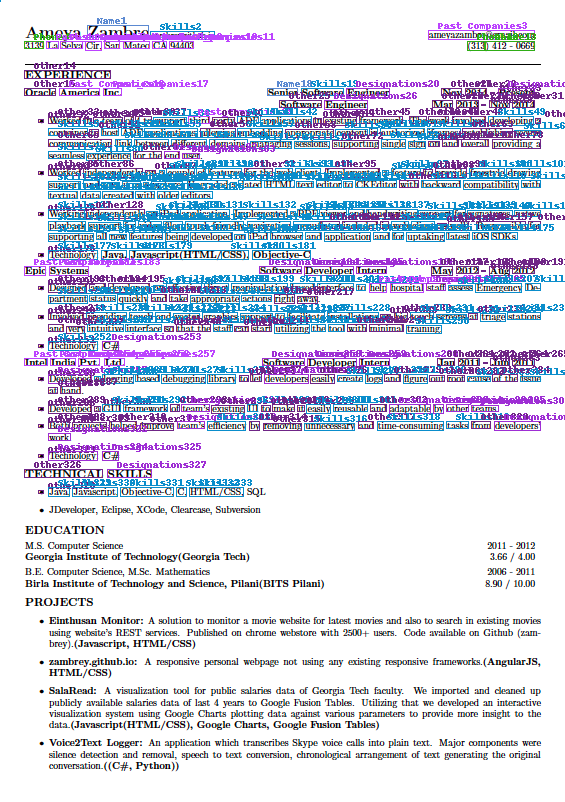

In [41]:
import random
from PIL import ImageDraw

get_colors = lambda n: list(map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF),range(n)))
colors = get_colors(len(labels))
draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
    label = label
    if not label:
      return 'other'
    return label

label2color = {label: colors[idx] for idx, label in enumerate(labels)}

count = 0
for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction)
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0]+10, box[1]-10), text=predicted_label + str(count), fill=label2color[predicted_label], font=font)
    count += 1
image

In [42]:
type(encoding)

transformers.tokenization_utils_base.BatchEncoding

In [43]:
len(encoding.word_ids())

512

In [44]:
tokens[encoding.word_ids()[214]]

'“'

In [45]:
encoding.words()[:10], encoding.tokens()[:10]

([None, 0, 0, 1, 1, 1, 1, 1, 2, 2],
 ['[CLS]',
  'lamb',
  '##re',
  'sami',
  '##ew',
  '##sin',
  '##ds',
  '##io',
  'am',
  '##ey'])

In [46]:
encoding.bbox[0][:10]

tensor([[  0,   0,   0,   0],
        [155,  32, 263,  47],
        [155,  32, 263,  47],
        [267,  39, 380,  49],
        [267,  39, 380,  49],
        [267,  39, 380,  49],
        [267,  39, 380,  49],
        [267,  39, 380,  49],
        [759,  38, 946,  49],
        [759,  38, 946,  49]], device='cuda:0')

In [47]:
for id in encoding.input_ids:
  for i, ident in enumerate(id):
    print(i, processor.tokenizer.decode(ident))

0 [CLS]
1 lamb
2 ##re
3 sami
4 ##ew
5 ##sin
6 ##ds
7 ##io
8 am
9 ##ey
10 ##az
11 ##am
12 ##bre
13 ##ti
14 ##gm
15 ##ail
16 .
17 com
18 43
19 ##15
20 ##0
21 la
22 se
23 ##va
24 cr
25 ,
26 san
27 mat
28 ##co
29 ca
30 94
31 ##40
32 ##3
33 (
34 gia
35 )
36 412
37 -
38 06
39 ##0
40 ##5
41 experience
42 ‘
43 oracle
44 america
45 inc
46 .
47 sen
48 ##lor
49 so
50 ##f
51 ##ware
52 engineer
53 ‘
54 nov
55 2014
56 -
57 present
58 ‘
59 software
60 engineer
61 ‘
62 mar
63 2013
64 -
65 nov
66 2014
67 ‘
68 +
69 worked
70 ina
71 team
72 of
73 to
74 support
75 third
76 party
77 ad
78 ##f
79 applications
80 in
81 existing
82 framework
83 .
84 the
85 work
86 involved
87 dev
88 ##eo
89 ##ping
90 a
91 container
92 to
93 host
94 ad
95 ##f
96 applications
97 ,
98 allowing
99 em
100 ##bed
101 ##ding
102 appropriate
103 content
104 in
105 authorized
106 ames
107 ,
108 establishing
109 secure
110 ‘
111 com
112 ##mini
113 ##ation
114 ink
115 bet
116 ##wen
117 different
118 .
119 domains
120 ,
121 managing
122 s

In [48]:
encoding.words()[486]

323

In [49]:
tokens[486]

'technology'